In [1]:
# Imports !

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import scipy.stats as stats
import pylab as pl
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten

In [2]:
# Gather data into dataframes

traffic_main_df = pd.read_csv('traffic_counts_datasd.csv')
intersections_df = pd.read_csv('Intersections.csv')
caltrans_df = pd.read_csv('Caltrans.csv')

In [3]:
# Perform data cleaning on the dataframes

# Remove directional columns from traffic_counts
traffic_main_df.drop('id', 1, inplace=True)
traffic_main_df.drop('northbound_count', 1, inplace=True)
traffic_main_df.drop('southbound_count', 1, inplace=True)
traffic_main_df.drop('all_count', 1, inplace=True)
traffic_main_df.drop('eastbound_count', 1, inplace=True)
traffic_main_df.drop('westbound_count', 1, inplace=True)
traffic_main_df.drop('file_no', 1, inplace=True)
traffic_main_df.drop('count_date', 1, inplace=True)

#Drop any rows with NaN values in traffic_main counts
traffic_main_df.dropna(inplace=True) 

In [4]:
# Data cleaning on intersections data

intersections_df.drop('Document ID', 1, inplace=True)
intersections_df.drop('Remote ID', 1, inplace=True)
intersections_df.drop('Filename', 1, inplace=True)
intersections_df.drop('Received At', 1, inplace=True)
intersections_df.drop('Processed At', 1, inplace=True)

# Drop any rows with NaN values in traffic_main counts
intersections_df.dropna(inplace=True)

# Clean out new page headers (extracted from PDF)
intersections_df = intersections_df[intersections_df['1st Cross Street'] != '1st Cross Street']

# Clean the traffic count values (get rid of tail symbols e.g. 'N', 'S', etc.)
for index, row in intersections_df.iterrows():
    row['2009'] = row['2009'].split()[0]
    row['2010'] = row['2010'].split()[0]
    row['2011'] = row['2011'].split()[0]
    row['2012'] = row['2012'].split()[0]
    row['2013'] = row['2013'].split()[0]

# Taking the average traffic of all the years (2009 - 2013) and storing it in a column called "Average AADT"
intersections_df['Average AADT'] = 0
for i, row in intersections_df.iterrows():
    avg = int((int(row['2009']) + int(row['2010']) + int(row['2011']) 
                                                    + int(row['2012']) + int(row['2013']))) / 5
    intersections_df.set_value(i, 'Average AADT', avg) 

intersections_df.head()

,Primary Street,1st Cross Street,2nd Cross Street,2009,2010,2011,2012,2013,Average AADT
0,A ST,KETTNER BLVD,INDIA ST,5100,6100,6100,6100,6100,5900
1,A ST,INDIA ST,COLUMBIA ST,7900,6800,6800,6800,6800,7020
2,A ST,COLUMBIA ST,FRONT ST,8700,10100,10100,10100,8800,9560
3,A ST,FRONT ST,1ST AVE,12600,12000,9300,9300,11400,10920
4,A ST,1ST AVE,4TH AVE,11500,10800,10800,10800,10800,10940


In [5]:
# Data cleaning on caltrans dataframe

caltrans_df.drop('Caltrans District ID Number', 1, inplace=True)
caltrans_df.drop('Route Suffix', 1, inplace=True)
caltrans_df.drop('Postmile Prefix', 1, inplace=True)
caltrans_df.drop('Postmile Number', 1, inplace=True)
caltrans_df.drop('Postmile Suffix', 1, inplace=True)
caltrans_df.drop('South or Westbound Peak Hour', 1, inplace=True)
caltrans_df.drop('South or Westbound Peak Month', 1, inplace=True)
caltrans_df.drop('North or Eastbound Peak Hour', 1, inplace=True)
caltrans_df.drop('North or Eastbound Peak Month', 1, inplace=True)


In [6]:
# Retrieve only San Diego county data
caltrans_df = caltrans_df[caltrans_df['County'] == "San Diego"]

# fill all NaN traffic values (directional) with 0's for average computation
caltrans_df['South or Westbound Annual Average Daily Traffic (AADT)'].fillna(0, inplace=True)
caltrans_df['North or Eastbound Annual Average Daily Traffic (AADT)'].fillna(0, inplace=True)

# append a new column with consolidated directional traffic counts (S/W + N/E)
caltrans_df['Total Average Daily Traffic (TADT)'] = (
    caltrans_df['South or Westbound Annual Average Daily Traffic (AADT)'] +
    caltrans_df['North or Eastbound Annual Average Daily Traffic (AADT)'])

In [7]:
# Create a dictionary of street-range locations to total_count
main_dict = dict()
main_counts = dict() # keeps track of # of keys found

for i, row in traffic_main_df.iterrows():
    keytp = (row['street_name'], row['limits'])
    # If key already exists in the dictionary, append to count and take sum of traffic values
    if keytp in main_dict:
        main_counts[keytp] = main_counts[keytp] + 1
        main_dict[keytp] = (main_dict[keytp] + row['total_count'])
    # Otherwise, initialize key to traffic value and count to 1
    else:
        main_counts[keytp] = 1
        main_dict[keytp] = row['total_count']

# Computing final average of all traffic values
for key in main_dict:
    main_dict[key] = main_dict[key] / main_counts[key]

total_traffic = dict()
for key in main_dict:
    street = str(key[0])
    if street in total_traffic.keys():
        total_traffic[street] = total_traffic[street] + main_dict[key]
    else:
        total_traffic[street] = main_dict[key]

total_traffic = {x:y for x,y in total_traffic.items() if y!=0}
        

In [8]:
# Creating dictionary for intersection pairs

inter_dict = dict()

for i, row in intersections_df.iterrows():
    key = (row['Primary Street'], row['1st Cross Street'], row['2nd Cross Street'])
    # Initialize key to intersection value 
    inter_dict[key] = row['Average AADT']

In [9]:
# Data Visualization
from pandas.tools.plotting import scatter_matrix



In [10]:
# Figuring out a way to hone in on the top 10 roads and manually calculating the widths/no of lanes (to )
# Equations for cost, energy generated, reducing carbon footprint
# cross referencing over the three ways to compute top 10
# consider expanding across the road that we determined

#         multiply all values by traffic volume
# cost depends on (number of lanes, how long the segment is) each ($202,626 per lane, 1 km strip) ($326,095 per lane for 1 mi)
# energy generated depends on (worst case, 20 mpg car generates 0.19 MJ by travelling 1 km strip) saving (0.305776 MJ per 1 mi)
    # How much is 1 MJ in San Diego county = 21.1 cents per kilowatt hour in san diego (277.78 W. h converts to 1 MJ)
# carbon footprint emissions (percentage saved)

# We want to do a linear regression analysis with traffic volumes, but need to find another parameter that is relevant
# any ideas?

# k-means: whole map: how much energy would we expect from a specific road? (k-means into 3 buckets)
# discuss reasonable constraints: small no of very busy roads, more problematic to interfere with (best tradeoff)
# electricity closer to downtown - the best roads there?
# estimate number of lanes based on clusters (be clear on this part)

In [11]:
# K-means clustering to find groups of traffic volumes
# energy generated depends on (worst case, 20 mpg car generates 0.19 MJ by travelling 1 km strip)
# Make a new dataframe joining 

total_traffic
d1 = total_traffic.keys()
d1 = [i for i in range(len(d1))]
d2 = total_traffic.values()
d2 = [int(x) for x in d2]

d1w = whiten(d1)
d2w = whiten(d2)

In [12]:
data = np.vstack([d1w, d2w]).T

In [13]:
km = KMeans(n_clusters=5)
km.fit(data)
results = km.predict(data)

# Storing each datapoint in an individual cluster
l1 = list(total_traffic.keys())
clusters = {}
n = 0
for item in results:
    if item in clusters:
        clusters[item].append(l1[n])
    else:
        clusters[item] = [l1[n]]
    n+=1


#Rename keys in dictionary
#clusters["Yellow"] = clusters.pop(2)
#clusters["Teal"] = clusters.pop(1)
#for key in clusters:
#    print(key)
#clusters["Blue"] = clusters.pop(2)
#clusters["Purple"] = clusters.pop(0)
#clusters["Green"] = clusters.pop(3)

for item in clusters:
    print(item)
    print(clusters[item])
    print("\n")


0
['01 AV', '02 AV', '03 AV', '04 AV', '04  AV', '06 EX', '07 AV', '08 AV', '09 AV', '10 AV', '11 AV', '07  AV', '16 ST', '25 ST', '26 ST', '27 ST', '28 ST', '11  AV', '14TH  ST', '30 ST', '17 ST', '19 ST', '25  ST', '32 ST', '33 ST', '35 ST', '36 ST', '38 ST', '39 ST', '40 ST', '42 ST', '43 ST', '47 ST', '32ND  ST', '35TH  ST ', '37 ST', '38  ST', '55 ST', '58 ST', '41 ST', '60 ST', '61 ST', '62 ST', '63 ST', '65 ST', '69 ST', '43RD  ST', '45 ST', '47  ST', '70 ST', 'A ST', '49 ST', '50 ST', 'ABBOTT ST', '51 ST', '52 ST', 'ABER ST', 'ACACIA ST', 'ACORN ST', 'ACTIVITY RD', 'ACWORTH AV', 'ADAMS AV', 'ADOBE FALLS RD', 'ADRIAN ST', '54TH  ST', '54TH  ST ', '56 ST', 'AFTON RD', 'AIRWAY RD', '61  ST', 'AKINS AV', '62 AV', 'ALABAMA ST', 'ALBATROSS ST', 'ALCOTT ST', 'ALDINE DR', '68 ST', 'ALLEGHANY ST', 'ALMAZON ST', 'ALSACIA ST', 'ALTA VW DR', 'ALVARADO CYN RD', 'ALVARADO RD', 'ANTIGUA BL', 'APPLETON ST', 'ARAGON DR', 'ARBOR DR', 'ABBOTT  ST', 'AREY DR', 'ARIANE DR', 'ARJONS DR', 'ARMOUR ST'

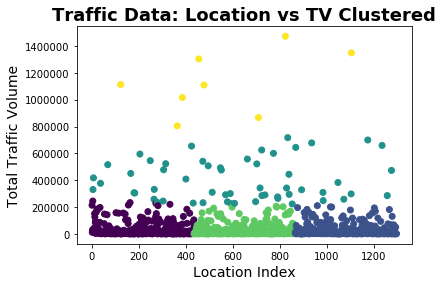

In [14]:
# Let's check out the clusters that KMeans found!!!!
plt.scatter(d1, d2, c=km.labels_);
plt.xlabel('Observation')
plt.ylabel('AADT')

# Add title, labels and legend
plt.title("Traffic Data: Location vs TV Clustered", fontsize=18, fontweight='bold')
plt.xlabel('Location Index', fontsize=14);
plt.ylabel('Total Traffic Volume', fontsize=14);

In [15]:
# Construct average traffic volume segments for each of the 5 clusters
map_avgs = dict()
currSum = 0
currCount = 0

for item in clusters:
    
    # We reset current sum and current count for each new cluster
    currSum = 0
    currCount = 0
    for loc in clusters[item]:
        currSum = currSum + total_traffic[loc]
        currCount = currCount + 1
    
    # set dictionary value
    map_avgs[item] = currSum / currCount

In [16]:
# Determine the location closest to the average traffic volume within each cluster:
for item in clusters:
    minDiff = 10000000000000.0
    optLoc = "N/A"
    
    for loc in clusters[item]:
        if (np.fabs(total_traffic[loc] - map_avgs[item]) < minDiff):
            minDiff = np.fabs(total_traffic[loc] - map_avgs[item])
            optLoc = loc
    print(item)
    print(optLoc)
    print(total_traffic[optLoc])
    print(minDiff)

0
ANTIGUA BL
28058.35
67.0795539069
2
EUCLID AV
408621.7083333334
9689.18340667
4
BALBOA AV
1112507.3063492063
16612.210119
3
MADISON AV
24672.333333333336
371.602101888
1
SCOTT ST
25080.11111111111
82.8786838924


In [17]:
# cost per lane per 1 mi * length in miles * number of lanes
def computeCost(miles, lanes):
    return 326095 * miles * lanes;

def computeEnergy(traffic_volume):
    return 0.305776 * traffic_volume;

# energy in MJ per 20 mpg car over 1 mi * kwh in 1 MJ * cents per kwh in San Diego * number of cars
def computeEnergyInDollars(traffic_volume):
    return 0.305776 * 277.78 * .211 * traffic_volume;

# net gain/loss is (energy's worth in $ - cost of implementation)
def computeSavings(energy, cost):
    return energy - cost;

In [23]:
# Create a dictionary storing information about type of street, optimal location within that category of street, 
# number of lanes approximation, energy generated approximation, and cost approximation

clusters_results = dict()

energy_scott = computeEnergy(total_traffic['SCOTT ST'])
energy_rev_scott = computeEnergyInDollars(total_traffic['SCOTT ST'])
cost_scott = computeCost(0.84,1)
savings_scott = computeSavings(energy_rev_scott, cost_scott)

energy_madison = computeEnergy(total_traffic['MADISON AV'])
energy_rev_madison = computeEnergyInDollars(total_traffic['MADISON AV'])
cost_madison = computeCost(1.55,2)
savings_madison = computeSavings(energy_rev_madison, cost_madison)

energy_antigua = computeEnergy(total_traffic['ANTIGUA BL'])
energy_rev_antigua = computeEnergyInDollars(total_traffic['ANTIGUA BL'])
cost_antigua = computeCost(2.04,5)
savings_antigua = computeSavings(energy_rev_antigua, cost_antigua)

energy_euclid = computeEnergy(total_traffic['EUCLID AV'])
energy_rev_euclid = computeEnergyInDollars(total_traffic['EUCLID AV'])
cost_euclid = computeCost(5.80,5)
savings_euclid = computeSavings(energy_rev_euclid, cost_euclid)

energy_balboa = computeEnergy(total_traffic['BALBOA AV'])
energy_rev_balboa = computeEnergyInDollars(total_traffic['BALBOA AV'])
cost_balboa = computeCost(5.92,9)
savings_balboa = computeSavings(energy_rev_balboa, cost_balboa)

clusters_results['Small:1'] = ("Energy Generated = " + str(energy_scott)+ " mJ", "Energy Revenue = $" + str(energy_rev_scott), "Cost = $" + str(cost_scott), "Savings = " + str(savings_scott), 
                               "Length = " + str(0.84), "Number of Lanes = " + str(1))
clusters_results['Small:2'] = ("Energy Generated = " + str(energy_madison)+ " mJ", "Energy Revenue = $" + str(energy_rev_madison), "Cost = $" + str(cost_madison), "Savings = " + str(savings_madison), 
                               "Length = " + str(1.55), "Number of Lanes = " + str(2))
clusters_results['Small:3'] = ("Energy Generated = " + str(energy_antigua)+ " mJ", "Energy Revenue = $" + str(energy_rev_antigua), "Cost = $" + str(cost_antigua), "Savings = " + str(savings_antigua), 
                               "Length = " + str(2.04), "Number of Lanes = " + str(5))
clusters_results['Medium'] = ("Energy Generated = " + str(energy_euclid)+ " mJ", "Energy Revenue = $" + str(energy_rev_euclid), "Cost = $" + str(cost_euclid), "Savings = " + str(savings_euclid), 
                              "Length = " + str(5.80), "Number of Lanes = " + str(5))
clusters_results['Large'] = ("Energy Generated = " + str(energy_balboa)+ " mJ", "Energy Revenue = $" + str(energy_rev_balboa), "Cost = $" + str(cost_balboa), "Savings = " + str(savings_balboa), 
                             "Length = " + str(5.92), "Number of Lanes = " + str(9))

print(clusters_results)

{'Small:1': ('Energy Generated = 7668.89605511111 mJ', 'Energy Revenue = $449486.11464582925', 'Cost = $273919.8', 'Savings = 175566.31464582926', 'Length = 0.84', 'Number of Lanes = 1'), 'Small:2': ('Energy Generated = 7544.207397333334 mJ', 'Energy Revenue = $442177.91540539445', 'Cost = $1010894.5', 'Savings = -568716.5845946055', 'Length = 1.55', 'Number of Lanes = 2'), 'Small:3': ('Energy Generated = 8579.5700296 mJ', 'Energy Revenue = $502862.15515550267', 'Cost = $3326169.0', 'Savings = -2823306.8448444973', 'Length = 2.04', 'Number of Lanes = 5'), 'Medium': ('Energy Generated = 124946.71148733335 mJ', 'Energy Revenue = $7323324.176076757', 'Cost = $9456755.0', 'Savings = -2133430.823923243', 'Length = 5.8', 'Number of Lanes = 5'), 'Large': ('Energy Generated = 340178.0341062349 mJ', 'Energy Revenue = $19938372.060260314', 'Cost = $17374341.599999998', 'Savings = 2564030.4602603167', 'Length = 5.92', 'Number of Lanes = 9')}


In [24]:
# define function: given any street, let's make predictions on energy, cost, profits, and more!

def getStreetInfo(street_name):
    print("Finding info for " + street_name + "...")
    for item in clusters:
        if street_name in clusters[item] and "SCOTT ST" in clusters[item]:
            print(clusters_results['Small:1'])
        elif street_name in clusters[item] and "MADISON AV" in clusters[item]:
            print(clusters_results["Small:2"])
        elif street_name in clusters[item] and "ANTIGUA BL" in clusters[item]:
            print(clusters_results["Small:3"])
        elif street_name in clusters[item] and "EUCLID AV" in clusters[item]:
            print(clusters_results["Medium"])
        elif street_name in clusters[item] and "BALBOA AV" in clusters[item]:
            print(clusters_results["Large"])
    print("\n")

getStreetInfo("GENESEE AV")
getStreetInfo("CONVOY ST")
getStreetInfo("HELLO ST")

Finding info for GENESEE AV...
('Energy Generated = 340178.0341062349 mJ', 'Energy Revenue = $19938372.060260314', 'Cost = $17374341.599999998', 'Savings = 2564030.4602603167', 'Length = 5.92', 'Number of Lanes = 9')


Finding info for CONVOY ST...
('Energy Generated = 8579.5700296 mJ', 'Energy Revenue = $502862.15515550267', 'Cost = $3326169.0', 'Savings = -2823306.8448444973', 'Length = 2.04', 'Number of Lanes = 5')


Finding info for HELLO ST...




In [ ]:
top10 = sorted(inter_dict, key=inter_dict.get, reverse=True)[:10]

In [ ]:
top10info = {}
for i in top10:
    top10info[i] = [i, inter_dict[i]]
    print(top10info[i])

In [ ]:
#manual entries of segment length in miles and average estimate of number of lanes in segment
#when doing calculations, could also normalize all of these with 1 mile and see how the costs and stuff look like with 
#   amount of cars and lanes

top10info[('FAIRMOUNT AVE', 'INTERSTATE 8', 'CAMINO DEL RIO SOUTH')].append(0.3)
top10info[('FAIRMOUNT AVE', 'INTERSTATE 8', 'CAMINO DEL RIO SOUTH')].append(6)

top10info[('NORTH HARBOR DR', 'WINSHIP LN', 'LAUREL ST')].append(0.7)
top10info[('NORTH HARBOR DR', 'WINSHIP LN', 'LAUREL ST')].append(7)

top10info[('CORONADO BRIDGE/ROUTE', '75 INTERSTATE 5', 'CITY LIMITS')].append(2.1)
top10info[('CORONADO BRIDGE/ROUTE', '75 INTERSTATE 5', 'CITY LIMITS')].append(5)

top10info[('MIRA MESA BLVD', 'WESTVIEW PKWY', 'INTERSTATE 15')].append(0.2)
top10info[('MIRA MESA BLVD', 'WESTVIEW PKWY', 'INTERSTATE 15')].append(9)

top10info[('FAIRMOUNT AVE', 'CAMINO DEL RIO SOUTH', 'MONTEZUMA RD')].append(0.3)
top10info[('FAIRMOUNT AVE', 'CAMINO DEL RIO SOUTH', 'MONTEZUMA RD')].append(6)

top10info[('WEST MISSION BAY DR', 'INGRAHAM ST', 'SEA WORLD DR')].append(0.3)
top10info[('WEST MISSION BAY DR', 'INGRAHAM ST', 'SEA WORLD DR')].append(6)

top10info[('MIRA MESA BLVD', 'BLACK MOUNTAIN DR', 'WESTVIEW PKWY')].append(0.3)
top10info[('MIRA MESA BLVD', 'BLACK MOUNTAIN DR', 'WESTVIEW PKWY')].append(7)

top10info[('PALM AVE/ROUTE 75', 'SATURN BLVD', 'INTERSTATE 5')].append(0.3)
top10info[('PALM AVE/ROUTE 75', 'SATURN BLVD', 'INTERSTATE 5')].append(6)

top10info[('MIRAMAR RD', 'CAMINO RUIZ', 'BLACK MOUNTAIN RD')].append(0.8)
top10info[('MIRAMAR RD', 'CAMINO RUIZ', 'BLACK MOUNTAIN RD')].append(6)

top10info[('MIRAMAR RD', 'NOBEL DR', 'EASTGATE MALL')].append(0.3)
top10info[('MIRAMAR RD', 'NOBEL DR', 'EASTGATE MALL')].append(7)

print(top10info)

In [ ]:
top10cost = {}
for i in top10info:
    # cost per lane per 1 mi * length in miles * number of lanes
    top10cost[i] = 326095 * top10info[i][2] * top10info[i][3]
    print(top10cost[i])

In [ ]:
top10energy = {}
for i in top10info:
    # energy in MJ per 20 mpg car over 1 mi * kwh in 1 MJ * cents per kwh in San Diego * number of cars
    top10energy[i] = 0.305776 * 277.78 * .211 * top10info[i][1]
    print(top10energy[i])

In [ ]:
top10savings = {}
for i in top10info:
    # cost of energy generated - cost of constructing
    top10savings[i] = top10energy[i] - top10cost[i]
    print(top10savings[i])

In [ ]:
top10results = []
for i in range(0, 10):
    top10results.append([top10[i], top10cost[top10[i]], top10energy[top10[i]], top10savings[top10[i]]])

In [ ]:
# segment, cost of building, energy generated cost, savings
for i in top10results:
    print(i)

In [ ]:
# profit models for any street, avenue, blvd, etc, NOT accounting for infrastructure costs, economic resources, and
# wear and tear.

def computeProfit(street_name):
    